In [1]:
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as p9
import scanpy as sc
import scvi
import torch
import muon as mu
from scipy.stats import pearsonr

/home/wuxinchao/.conda/envs/HE_ST/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
/home/wuxinchao/.conda/envs/HE_ST/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
/home/wuxinchao/.conda/envs/HE_ST/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
/home/wuxinchao/.conda/envs/HE_ST/lib/python3.9/site-packages/umap/distan

In [2]:
sc.set_figure_params(figsize=(4, 4))
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

# Data loading

In [3]:
def load_10x_h5(datafile):
    adata = sc.read_10x_h5(datafile, gex_only=False)
    print(adata)
    print(adata.var["feature_types"].value_counts())
    adata_rna = adata[:, adata.var["feature_types"] == "Gene Expression"]
    adata_prot = adata[:, adata.var["feature_types"] == "Antibody Capture"]
    mdata = mu.MuData({'rna': adata_rna, 'prot': adata_prot})
    return mdata

In [4]:
pbmc10k_datafile = "/DATA/User/wuxinchao/st_cite_data/10x_cite_seq/10k_pbmc_totalseqB.h5"

In [5]:
mdata = load_10x_h5(pbmc10k_datafile)
mdata

/home/wuxinchao/.conda/envs/HE_ST/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/wuxinchao/.conda/envs/HE_ST/lib/python3.9/site-packages/mudata/_core/mudata.py:479: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 7865 × 33555
    var: 'gene_ids', 'feature_types', 'genome'
Gene Expression     33538
Antibody Capture       17
Name: feature_types, dtype: int64


MuData object with n_obs × n_vars = 7865 × 33555
  var:	'gene_ids', 'feature_types', 'genome'
  2 modalities
    rna:	7865 x 33538
      var:	'gene_ids', 'feature_types', 'genome'
    prot:	7865 x 17
      var:	'gene_ids', 'feature_types', 'genome'

# RNA Preprocess

In [6]:
mdata.mod["rna"].var_names_make_unique()
mdata.var_names_make_unique()

/home/wuxinchao/.conda/envs/HE_ST/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [7]:
rna = mdata.mod["rna"]
prot = mdata.mod["prot"]

In [8]:
rna.layers["counts"] = rna.X.copy()
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)

In [9]:
sc.pp.highly_variable_genes(
    rna,
    n_top_genes=4000,
    flavor="seurat_v3",
    layer='counts',
)
mdata.mod["rna_subset"] = rna[:, rna.var["highly_variable"]].copy()

In [10]:
mdata.update()

/home/wuxinchao/.conda/envs/HE_ST/lib/python3.9/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.


In [14]:
sc.pp.scale(rna, max_value=10)
sc.tl.pca(rna, svd_solver='arpack')
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=40)
sc.tl.umap(rna)
sc.tl.leiden(rna, resolution=0.5)
sc.tl.rank_genes_groups(rna, 'leiden', method='t-test')

/home/wuxinchao/.conda/envs/HE_ST/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
/home/wuxinchao/.conda/envs/HE_ST/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
/home/wuxinchao/.conda/envs/HE_ST/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
/home/wuxinchao/.conda/envs/HE_ST/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
/home/wuxinchao/.conda/envs/HE_ST/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
/home/wuxinchao/.conda/envs/HE_ST/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
/home/wuxinchao/.conda/envs/HE_ST/lib/python3.9/site-packages/scanpy/tools/_rank_genes_g

In [15]:
result = rna.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.set_option('display.max_columns', 50)
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(10)

0_n  0_p     1_n            1_p     2_n  2_p     3_n  3_p       4_n  \
0     LYZ  0.0    TRAC   0.000000e+00   RPL30  0.0    NKG7  0.0      CD74   
1  S100A9  0.0    IL32   0.000000e+00   RPL32  0.0    GNLY  0.0   HLA-DRA   
2  S100A8  0.0     LTB  8.305758e-302   RPS3A  0.0    CTSW  0.0     CD79A   
3    CTSS  0.0   RPS4X  1.256480e-309   RPS12  0.0    GZMA  0.0  HLA-DRB1   
4    CST3  0.0  RPS15A   0.000000e+00   RPL11  0.0    CST7  0.0  HLA-DPB1   
5     FTL  0.0  EEF1A1  9.616452e-300  RPS27A  0.0   KLRD1  0.0     MS4A1   
6    FCN1  0.0    LDHB  6.042173e-268   RPS27  0.0     B2M  0.0  HLA-DQB1   
7     FOS  0.0   RPS27  4.246951e-302  RPS15A  0.0    PRF1  0.0  HLA-DPA1   
8  TYROBP  0.0   RPS18  3.342563e-275   RPS23  0.0    CCL5  0.0      CD37   
9    MNDA  0.0    RPS3  1.436370e-280   RPS25  0.0  FGFBP2  0.0  HLA-DQA1   

             4_p     5_n            5_p    6_n            6_p    7_n  \
0   0.000000e+00   RPS12  8.795408e-258  KLRB1  5.734493e-265   CCL5   
1   0.000000e+00   RPS27  1.834408e-302   GZMK  9.499711e-250   NKG7   
2   0.000000e+00  RPS27A  7.351347e-273   NKG7  1.013497e-186    B2M   
3   0.000000e+00   RPL30  1.651331e-257   IL7R  1.027764e-153   GZMA   
4   0.000000e+00   RPL32  1.211895e-225   IL32  1.494729e-159   CST7   
5  6.072725e-287   RPS3A  3.871984e-216  DUSP2  5.629362e-133   IL32   
6  1.389900e-291  RPS15A  4.246147e-233   CCL5  1.739791e-142   CTSW   
7  8.367465e-315    RPS3  2.623221e-229   CTSW  4.601271e-135  HLA-B   
8  3.678629e-288   RPL19  7.318415e-220   GZMA  4.175101e-129  HLA-C   
9  7.300284e-234   RPL13  8.667523e-217  ARL4C  1.854395e-103   CD3D   

             7_p      8_n            8_p     9_n            9_p      10_n  \
0  2.400909e-238   TYROBP  8.153306e-297     LYZ  5.543342e-106       VIM   
1  4.611503e-214      FTL  3.995389e-228     FTL   1.041370e-97     H2AFY   
2  4.675284e-162     CST3  1.441871e-208  S100A9   5.883977e-82      CD74   
3  8.879636e-138     FTH1  7.543189e-216    CST3   3.301521e-81    ARPC1B   
4  3.667146e-127     CTSS  2.877001e-226  S100A8   4.946742e-72   HLA-DRA   
5  4.421496e-129     AIF1  3.569700e-182    CTSS   2.119793e-67  HLA-DRB1   
6  1.120853e-118   FCER1G  6.598904e-184    FTH1   2.487016e-67     H3F3A   
7  9.162380e-113  S100A11  4.839126e-190  TYROBP   1.682978e-67     GSTP1   
8  1.256193e-104    COTL1  8.323734e-160   DUSP1   5.045430e-65   SLC25A5   
9   3.401757e-92    NEAT1  4.811314e-156     FOS   1.166584e-63     ARPC3   

           10_p     11_n          11_p      12_n          12_p       13_n  \
0  6.872246e-58   MT-ND4  5.657487e-43      MZB1  8.394756e-68       SOX4   
1  1.367217e-56  MT-ATP6  2.776866e-40    JCHAIN  3.488085e-67      HMGB1   
2  4.192406e-55   MT-ND3  2.666947e-38   HSP90B1  2.116052e-61       TUFM   
3  1.134708e-53   MT-CO2  1.291782e-37      PPIB  2.399823e-54     METAP2   
4  7.176392e-52   MT-CO1  7.570529e-36     SPCS2  7.509761e-54      PRDX6   
5  3.004592e-49   MT-CO3  9.415254e-36  TNFRSF17  1.769853e-51  HNRNPA2B1   
6  1.262412e-52   MT-CYB  9.196647e-34     PDIA4  1.945232e-48       CCNI   
7  1.311601e-49   MT-ND5  1.073760e-26    SEC11C  8.903016e-48      H3F3A   
8  1.317593e-48   MT-ND2  1.297617e-22     ITM2C  8.300427e-47      CAPN1   
9  2.944955e-50   MT-ND1  4.045771e-22    UBE2J1  1.711832e-44       XIST   

       13_p  
0  0.000005  
1  0.000004  
2  0.000026  
3  0.000058  
4  0.000084  
5  0.000089  
6  0.000153  
7  0.000220  
8  0.000232  
9  0.000238

In [16]:
mdata.update()

/home/wuxinchao/.conda/envs/HE_ST/lib/python3.9/site-packages/mudata/_core/mudata.py:322: UserWarning: Duplicated var_names should not be present in different modalities due to the ambiguity that leads to.
/home/wuxinchao/.conda/envs/HE_ST/lib/python3.9/site-packages/mudata/_core/mudata.py:479: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
/home/wuxinchao/.conda/envs/HE_ST/lib/python3.9/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.


# Protein Preprocess

In [11]:
from muon import prot as pt

In [12]:
prot.layers["counts"] = prot.X.copy()
pt.pp.clr(prot)
prot

/home/wuxinchao/.conda/envs/HE_ST/lib/python3.9/site-packages/muon/_prot/preproc.py:219: UserWarning: adata.X is sparse but not in CSC format. Converting to CSC.


AnnData object with n_obs × n_vars = 7865 × 17
    var: 'gene_ids', 'feature_types', 'genome'
    layers: 'counts'

In [13]:
mdata.update()
mdata

/home/wuxinchao/.conda/envs/HE_ST/lib/python3.9/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.


MuData object with n_obs × n_vars = 7865 × 37555
  var:	'gene_ids', 'feature_types', 'genome'
  3 modalities
    rna:	7865 x 33538
      var:	'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
      uns:	'log1p', 'hvg'
      layers:	'counts'
    prot:	7865 x 17
      var:	'gene_ids', 'feature_types', 'genome'
      layers:	'counts'
    rna_subset:	7865 x 4000
      var:	'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
      uns:	'log1p', 'hvg'
      layers:	'counts'

# Setup mudata

In [78]:
# rna.var['mt'] = rna.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
# sc.pp.calculate_qc_metrics(rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [14]:
mdata = mu.MuData({'rna': mdata.mod["rna_subset"], 'prot': prot})

In [15]:
mdata = mdata.copy()
scvi.model.TOTALVI.setup_mudata(
    mdata,
    rna_layer="counts",
    protein_layer="counts",
    modalities={
        "rna_layer": "rna",
        "protein_layer": "prot",
    },
)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


# Prepare and run model

In [16]:
mdata.mod["prot"].layers["counts"] = mdata.mod["prot"].layers["counts"].toarray()

In [17]:
model = scvi.model.TOTALVI(mdata, empirical_protein_background_prior=True)

INFO     Computing empirical prior initialization for protein background.                                          


In [18]:
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wuxinchao/.conda/envs/HE_ST/lib/python3.9/site-packages/lightning/pytorch/core/optimizer.py:321: RuntimeWarning: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.


Epoch 387/400:  97%|████████████████████████████████████████▋ | 387/400 [04:46<00:09,  1.35it/s, v_num=1, train_loss_step=1.36e+3, train_loss_epoch=1.31e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 1308.693. Signaling Trainer to stop.


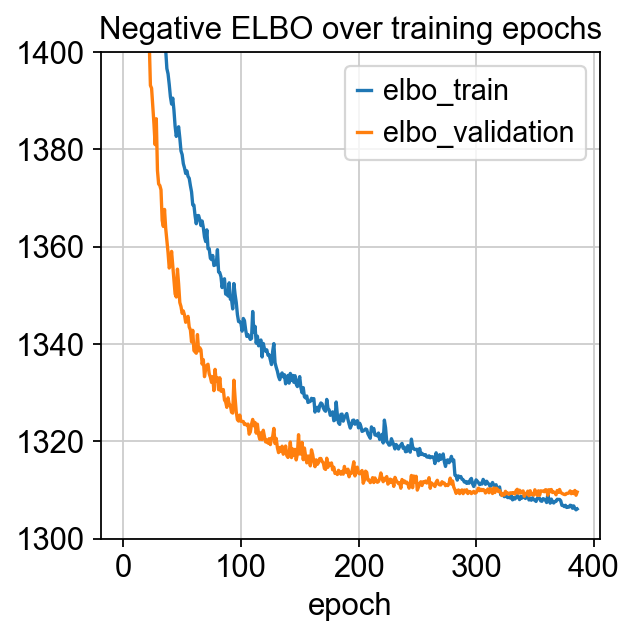

In [21]:
fig, ax = plt.subplots(1, 1)
model.history["elbo_train"].plot(ax=ax, label="train")
model.history["elbo_validation"].plot(ax=ax, label="validation")
ax.set(title="Negative ELBO over training epochs", ylim=(1300, 1400))
ax.legend()

# Analyze outputs

In [24]:
rna = mdata.mod["rna"]
protein = mdata.mod["prot"]

In [25]:
# arbitrarily store latent in rna modality
TOTALVI_LATENT_KEY = "X_totalVI"
rna.obsm[TOTALVI_LATENT_KEY] = model.get_latent_representation()

In [27]:
model.get_normalized_expression(n_samples=25, return_mean=True)

In [29]:
rna.obs["batch_key"] = "PBMC10K"

In [33]:
rna_denoised, protein_denoised = model.get_normalized_expression(
    n_samples=25, return_mean=True,
)

In [34]:
rna.layers["denoised_rna"] = rna_denoised
protein.layers["denoised_protein"] = protein_denoised

protein.layers[
    "protein_foreground_prob"
] = 100 * model.get_protein_foreground_probability(
    n_samples=25, return_mean=True
)
parsed_protein_names = [p.split("_")[0] for p in protein.var_names]
protein.var["clean_names"] = parsed_protein_names
mdata.update()

In [35]:
TOTALVI_CLUSTERS_KEY = "leiden_totalVI"

sc.pp.neighbors(rna, use_rep=TOTALVI_LATENT_KEY)
sc.tl.umap(rna)
sc.tl.leiden(rna, key_added=TOTALVI_CLUSTERS_KEY)
mdata.update()

/home/wuxinchao/.conda/envs/HE_ST/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


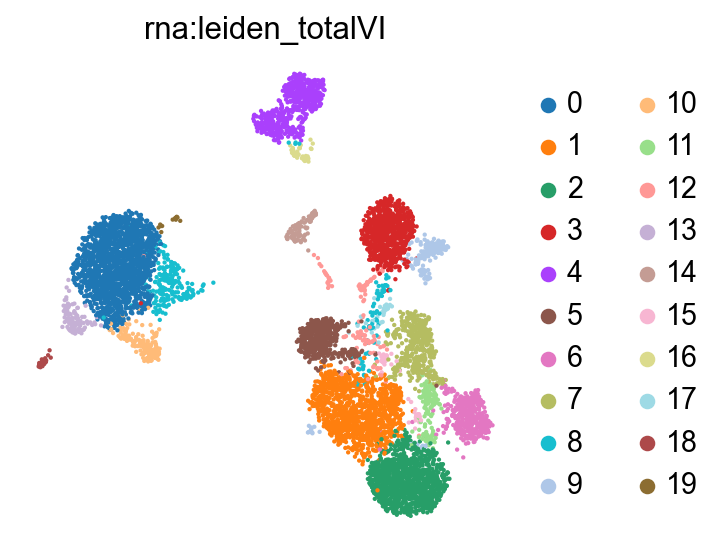

In [38]:
mu.pl.embedding(
    mdata,
    basis="rna:X_umap",
    color=[f"rna:{TOTALVI_CLUSTERS_KEY}"],
    frameon=False,
    ncols=1,
)

## Visualize denoised protein values

/home/wuxinchao/.conda/envs/HE_ST/lib/python3.9/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.


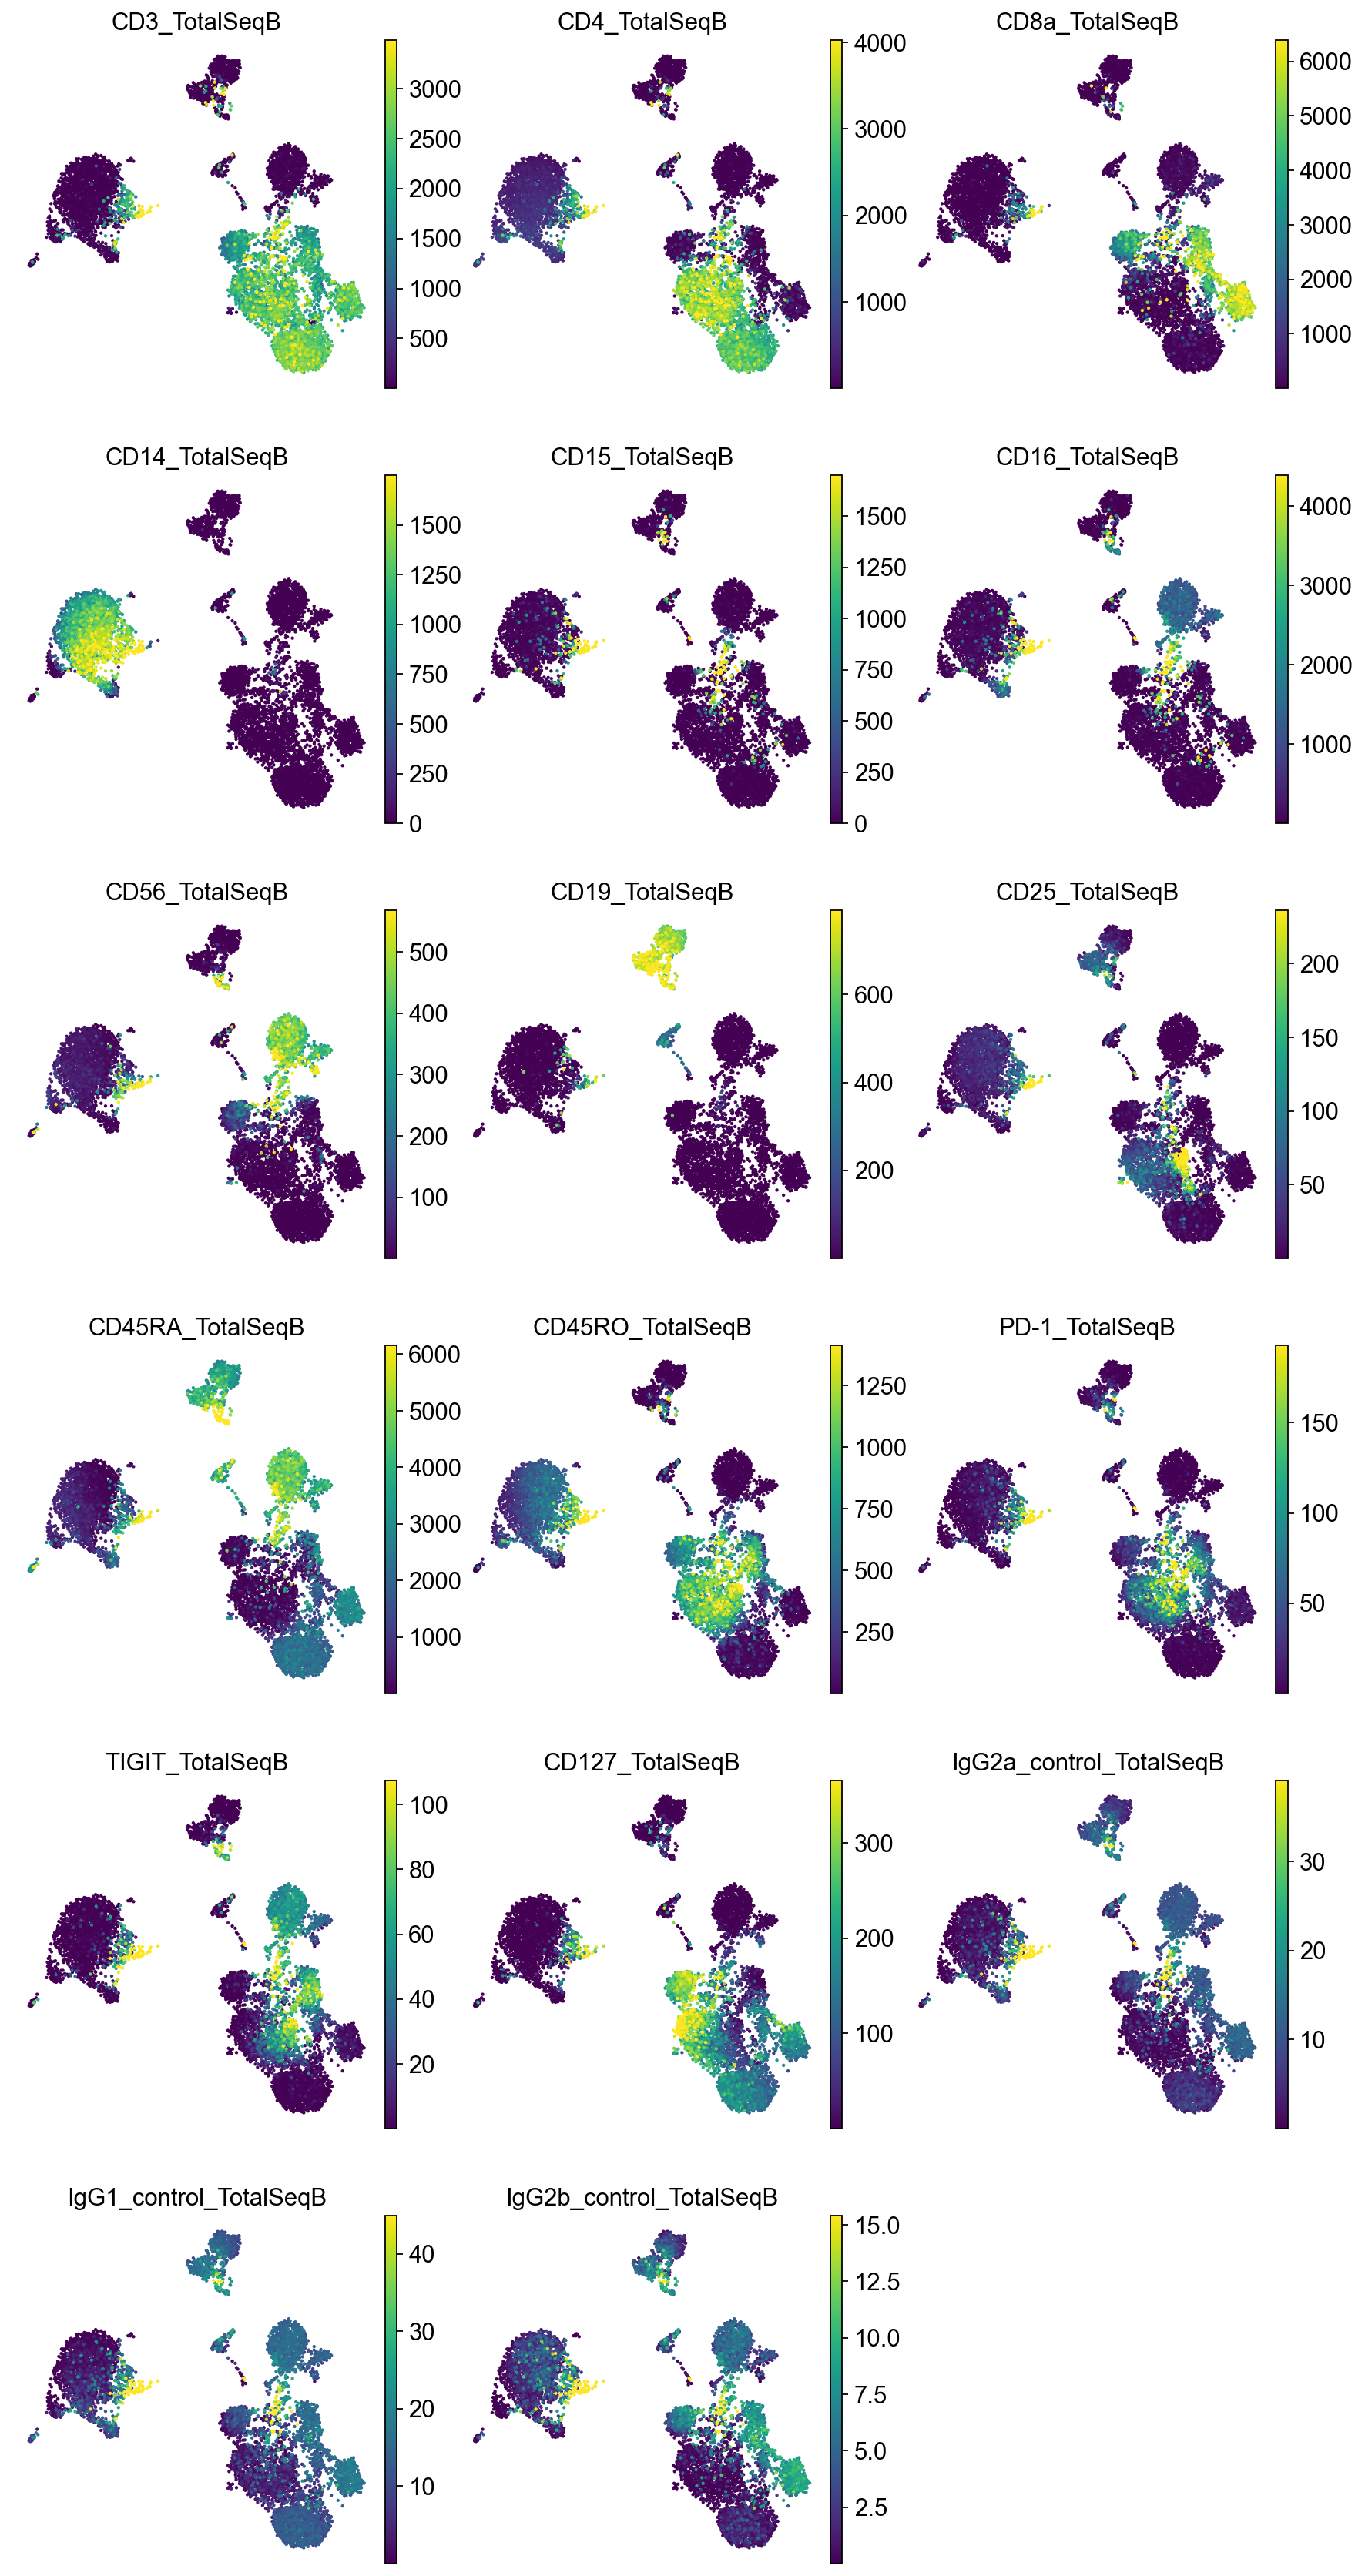

In [40]:
mu.pl.embedding(
    mdata,
    basis="rna:X_umap",
    color=protein.var_names,
    frameon=False,
    ncols=3,
    vmax="p99",
    wspace=0.1,
    layer="denoised_protein",
)

## Visualize probability of foreground
Some proteins are easier to disentangle than other, but others end up being "all background"

By viewing the foreground probability, we can get a feel for the types of cells in our dataset. For example, it's very easy to see a population of monocytes based on the CD14 foreground probability

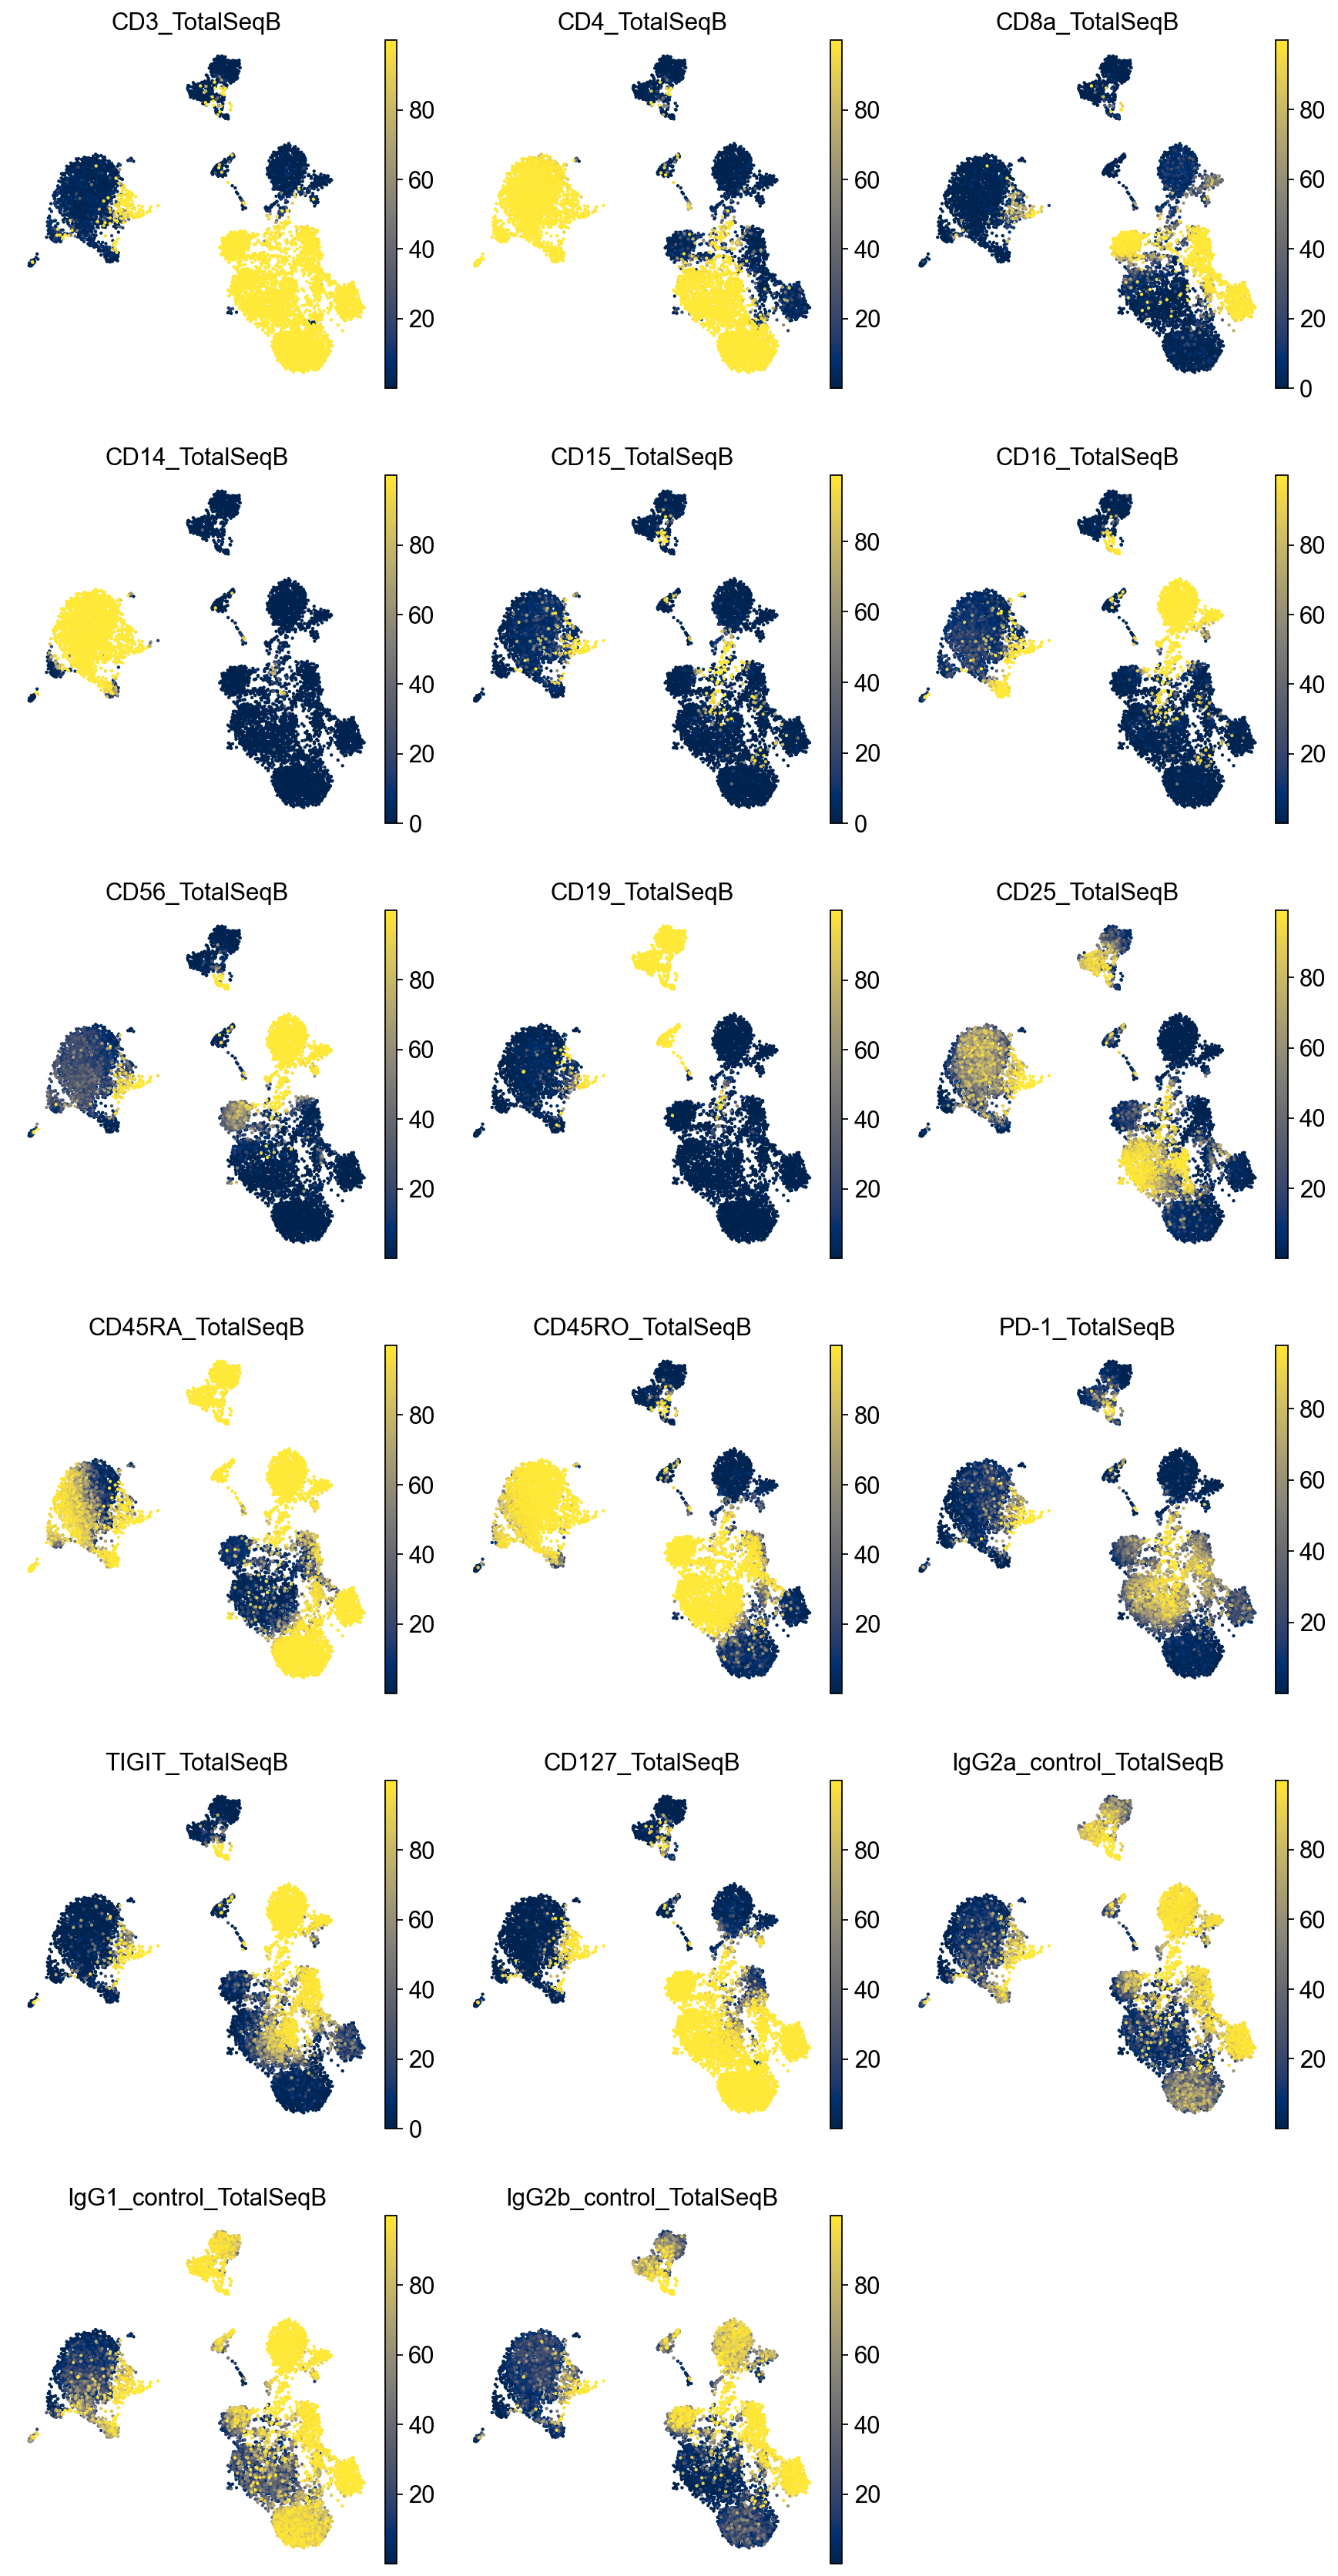

In [41]:
mu.pl.embedding(
    mdata,
    basis="rna:X_umap",
    layer="protein_foreground_prob",
    color=protein.var_names,
    frameon=False,
    ncols=3,
    vmax="p99",
    wspace=0.1,
    color_map="cividis",
)

# Differential expression

In [42]:
de_df = model.differential_expression(
    groupby="rna:leiden_totalVI", delta=0.5, batch_correction=True
)
de_df.head(5)

DE...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:20<00:00,  4.05s/it]


proba_de  proba_not_de  bayes_factor        scale1    scale2  \
HELLS      0.9960        0.0040      5.517450  6.879459e-07  0.000055   
TRIB2      0.9956        0.0044      5.421739  1.823605e-06  0.000143   
TMEM156    0.9954        0.0046      5.377086  1.256409e-06  0.000109   
TMEM14A    0.9950        0.0050      5.293303  5.100019e-07  0.000080   
ITM2A      0.9946        0.0054      5.215940  2.963573e-06  0.000736   

         pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  raw_mean1  \
HELLS             0.0    0.5 -6.561277   -6.700031  1.938737  ...   0.002299   
TRIB2             0.0    0.5 -6.447491   -6.601900  2.017290  ...   0.002299   
TMEM156           0.0    0.5 -7.288141   -7.399808  2.096673  ...   0.002874   
TMEM14A           0.0    0.5 -7.911622   -8.143835  2.026340  ...   0.000000   
ITM2A             0.0    0.5 -8.507732   -8.849453  2.533186  ...   0.006897   

         raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
HELLS     0.075592               0.002299               0.051429   
TRIB2     0.136980               0.002299               0.113959   
TMEM156   0.124571               0.002874               0.102204   
TMEM14A   0.078367               0.000000               0.071184   
ITM2A     0.633138               0.005747               0.377143   

         raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  \
HELLS                0.009099              0.565022            True   
TRIB2                0.011778              1.465005            True   
TMEM156              0.010699              1.094771            True   
TMEM14A              0.000000              0.804820            True   
ITM2A                0.028975              7.683045            True   

         comparison  group1 group2  
HELLS     0 vs Rest       0   Rest  
TRIB2     0 vs Rest       0   Rest  
TMEM156   0 vs Rest       0   Rest  
TMEM14A   0 vs Rest       0   Rest  
ITM2A     0 vs Rest       0   Rest  

[5 rows x 22 columns]

In [43]:
filtered_pro = {}
filtered_rna = {}
cats = rna.obs[TOTALVI_CLUSTERS_KEY].cat.categories
for i, c in enumerate(cats):
    cid = f"{c} vs Rest"
    cell_type_df = de_df.loc[de_df.comparison == cid]
    cell_type_df = cell_type_df.sort_values("lfc_median", ascending=False)

    cell_type_df = cell_type_df[cell_type_df.lfc_median > 0]

    pro_rows = cell_type_df.index.str.contains("TotalSeqB")
    data_pro = cell_type_df.iloc[pro_rows]
    data_pro = data_pro[data_pro["bayes_factor"] > 0.7]

    data_rna = cell_type_df.iloc[~pro_rows]
    data_rna = data_rna[data_rna["bayes_factor"] > 3]
    data_rna = data_rna[data_rna["non_zeros_proportion1"] > 0.1]

    filtered_pro[c] = data_pro.index.tolist()[:3]
    filtered_rna[c] = data_rna.index.tolist()[:2]

In [44]:
sc.tl.dendrogram(rna, groupby=TOTALVI_CLUSTERS_KEY, use_rep=TOTALVI_LATENT_KEY)
# This is a bit of a hack to be able to use scanpy dendrogram with the protein data
protein.obs[TOTALVI_CLUSTERS_KEY] = rna.obs[TOTALVI_CLUSTERS_KEY]
protein.obsm[TOTALVI_LATENT_KEY] = rna.obsm[TOTALVI_LATENT_KEY]
sc.tl.dendrogram(protein, groupby=TOTALVI_CLUSTERS_KEY, use_rep=TOTALVI_LATENT_KEY)

/home/wuxinchao/.conda/envs/HE_ST/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


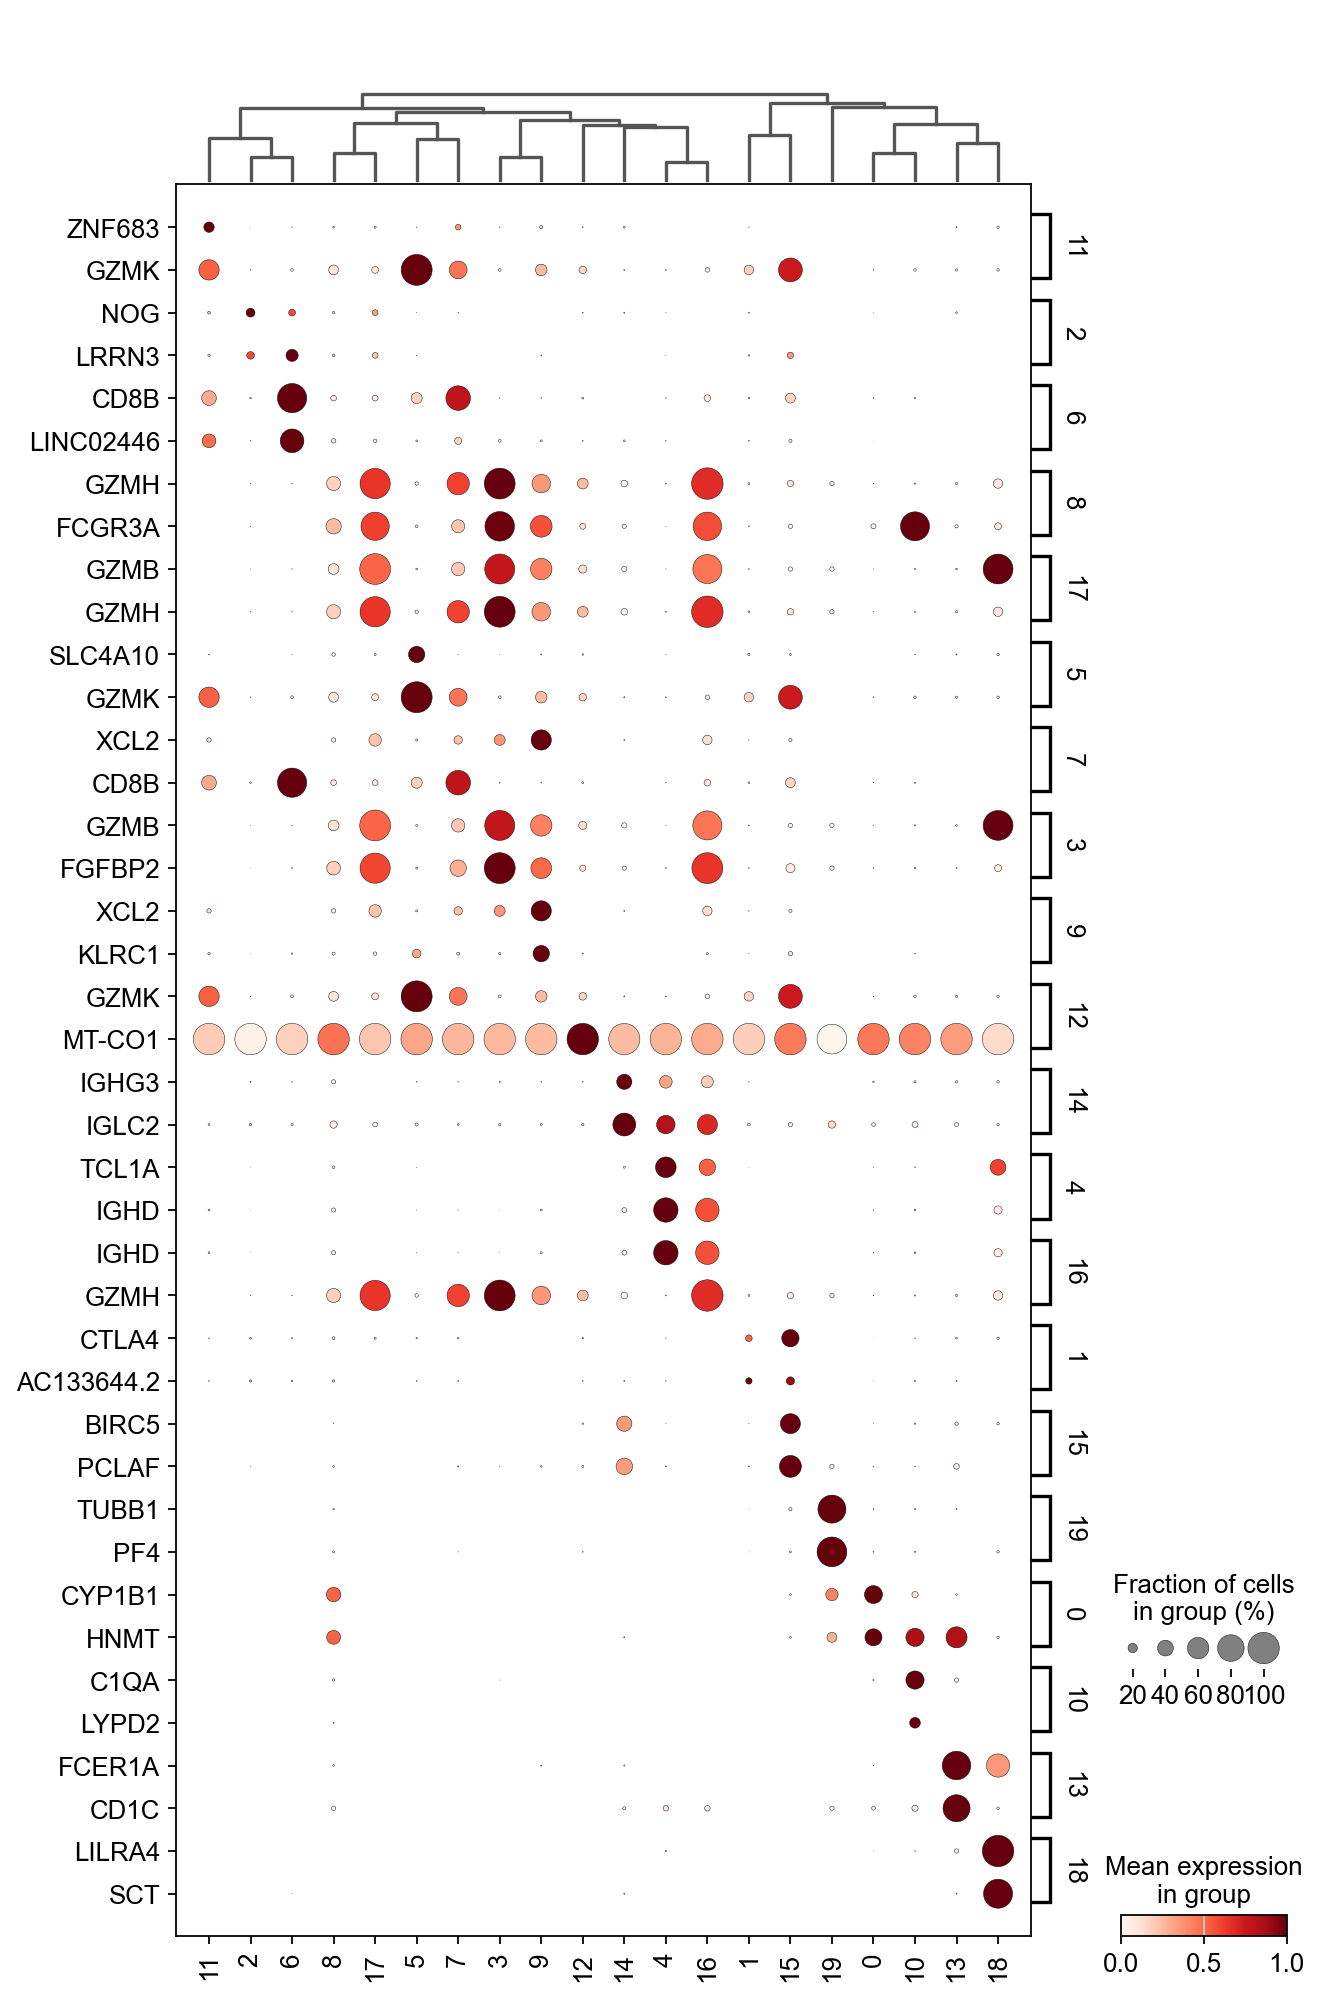

In [45]:
sc.pl.dotplot(
    rna,
    filtered_rna,
    groupby=TOTALVI_CLUSTERS_KEY,
    dendrogram=True,
    standard_scale="var",
    swap_axes=True,
)

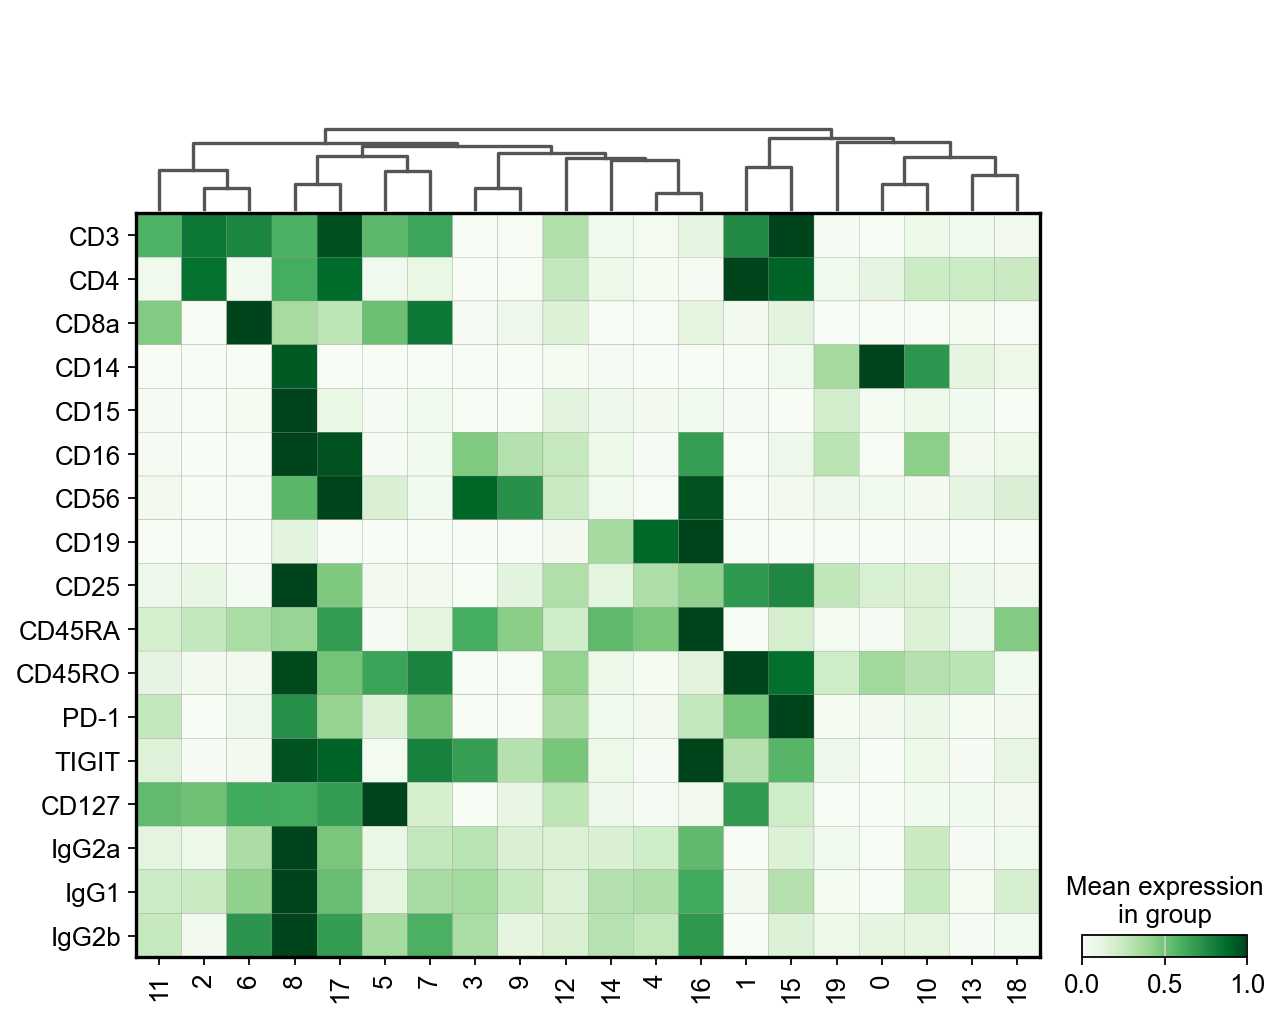

In [46]:
sc.pl.matrixplot(
    protein,
    protein.var["clean_names"],
    groupby=TOTALVI_CLUSTERS_KEY,
    gene_symbols="clean_names",
    dendrogram=True,
    swap_axes=True,
    layer="denoised_protein",
    cmap="Greens",
    standard_scale="var",
)

/home/wuxinchao/.conda/envs/HE_ST/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


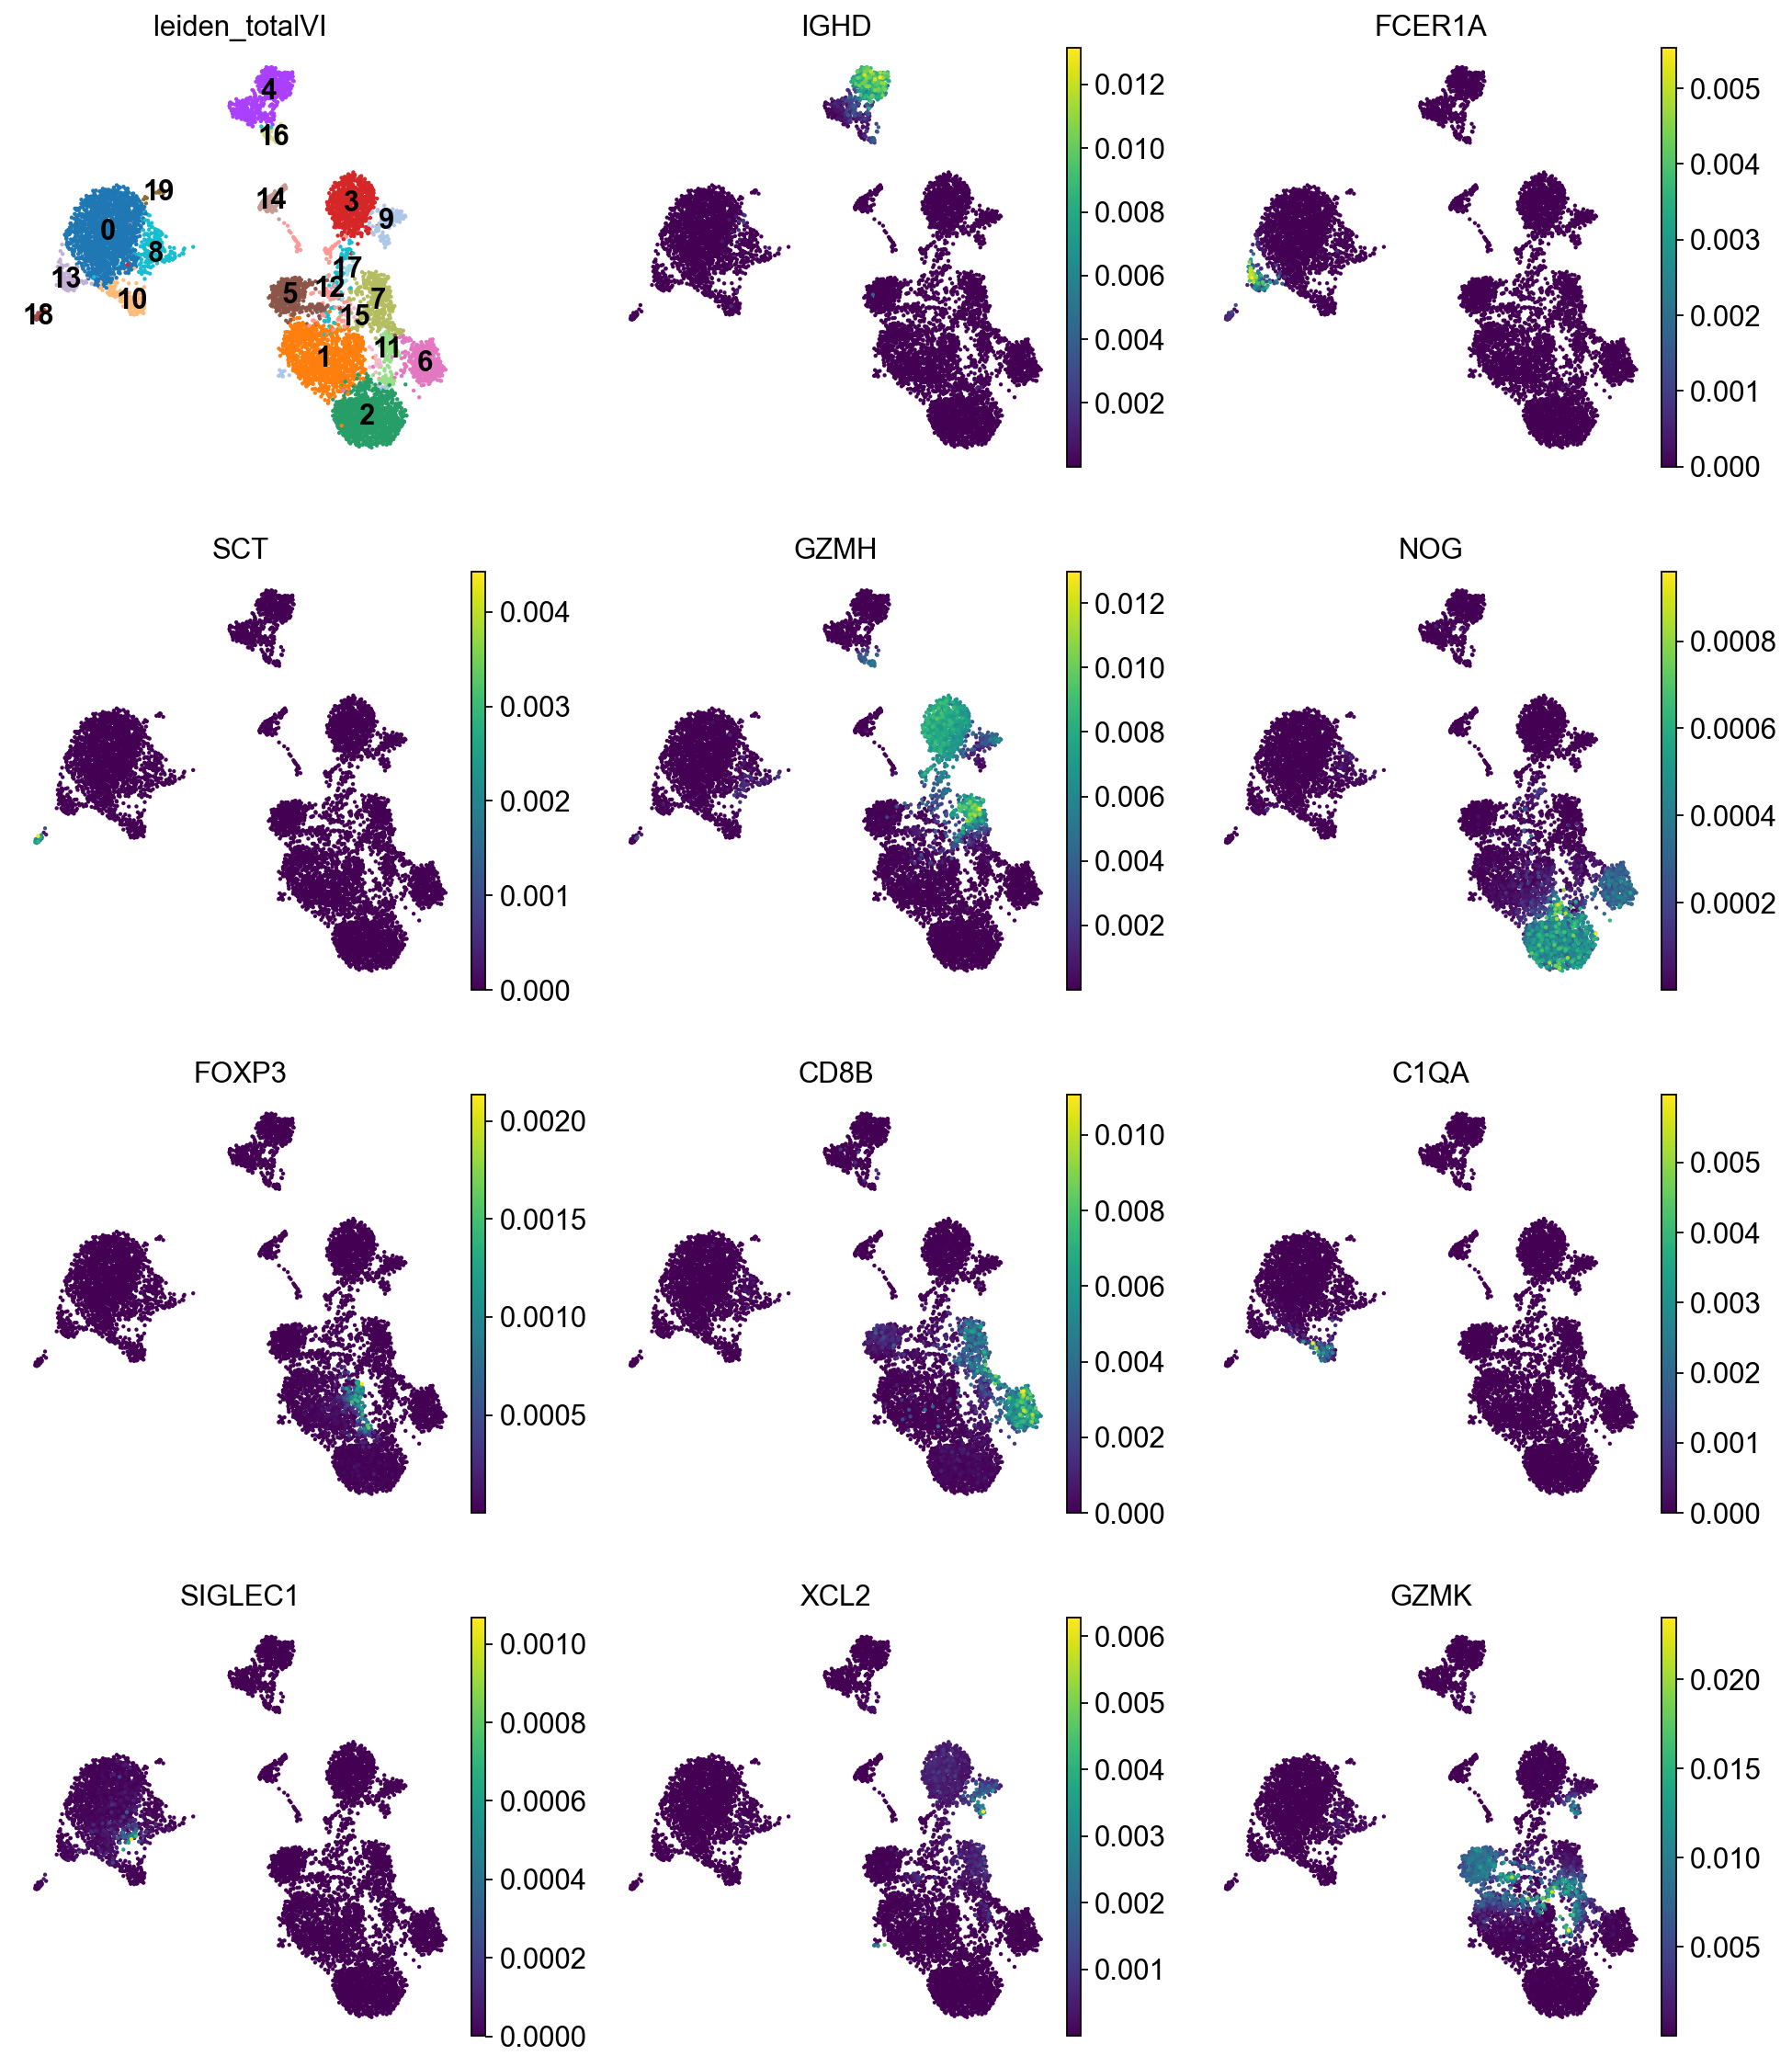

In [47]:
sc.pl.umap(
    rna,
    color=[
        TOTALVI_CLUSTERS_KEY,
        "IGHD",
        "FCER1A",
        "SCT",
        "GZMH",
        "NOG",
        "FOXP3",
        "CD8B",
        "C1QA",
        "SIGLEC1",
        "XCL2",
        "GZMK",
    ],
    legend_loc="on data",
    frameon=False,
    ncols=3,
    layer="denoised_rna",
    wspace=0.2,
)

In [51]:
save_dir = "/home/wuxinchao/data/project/spatial-CITE-seq/mid_result/"
mdata.write_h5mu(f"{save_dir}pbmc10k_totalseqB.h5mu")

/home/wuxinchao/.conda/envs/HE_ST/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/wuxinchao/.conda/envs/HE_ST/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Using Spatial Graph Cross-attention network